In [1]:
from __future__ import annotations
from typing import Callable, List
from random import choices, random, seed, gauss

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(font="JetBrainsMono NF", style="whitegrid")

In [2]:
# created a utility Point class to allow easy vector arithmetics
class Point[T]:
    # create a new `Point`
    def __init__(self, *coords, length: int | None = None, **_) -> None:
        if length is not None and length <= len(coords):
            raise AttributeError("invalid point length")

        self.length: int = length or len(coords)

        if isinstance(coords[0], list):
            self.length = length or len(coords[0])
            self.coords = coords[0][: self.length]
        else:
            self.coords = coords[: self.length]

    # add two `Point`s
    def __add__(self, other: Point) -> Point:
        return Point(*[xi + yi for xi, yi in zip(self.coords, other.coords)])

    # subtract two `Point` `self` from `other`
    def __sub__(self, other: Point) -> Point:
        return Point(*[xi - yi for xi, yi in zip(self.coords, other.coords)])

    # multiply all elements of a `Point` with a `factor`
    def __mul__(self, factor: float | int) -> Point:
        return Point([xi * factor for xi in self.coords])

    # perform dot product of two `Point`s
    def dot(self, other: Point) -> float:
        return sum(xi * yi for xi, yi in zip(self.coords, other.coords))

    # returns teh squared norm of a `Point`
    def norm2(self) -> float:
        return self.dot(self)

    # applies a function `fn` to each element of a `Point`
    def apply[U](self, fn: Callable[[T], U]) -> Point[U]:
        return Point[U]([fn(xi) for xi in self.coords])

    # converts `Point` to `str`
    def __str__(self) -> str:
        return f"<{','.join([str(x) for x in self.coords])}>"

    # returns the `repr()` output of a `Point`
    def __repr__(self) -> str:
        return self.__str__()
    
    def _getitem__(self, index: int) -> T:
        assert 0 <= index < self.length or -1 <= index < -self.length
        return self.coords[index]

In [3]:
class KMeansClustering:
    def __init__(
        self,
        *,
        n_clusters: int,
        tol: float = 1e-4,
        max_iter: int = 1000,
        random_state: int | None = None,
    ) -> None:
        """
        `n_cluster`: no. of clusters (K),
        `max_iter`: maximum no. of iterations before forced stopping,
        `tol`: minimum tolerance allowed for the loss, and
        `random_state`: initialize with an int to make reproducible clusters
        """

        if isinstance(random_state, int):
            seed(random_state)

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

        # cumulative inertias for each iteration
        self.inertias: List[float] = []
        # labels assigned to each point
        self.labels: List[int] | None = None
        # list of cluster centers
        self.centers: List[Point[float]] = []
        # list of points in each cluster
        self.clusters: List[List[Point[float]]] = []

    def _objective(self) -> float:
        "returns the Within cluster Square of Sums (WCSS) our loss function"
        total: float = 0
        for i, cluster in enumerate(self.clusters):
            if len(cluster) > 0:
                total += sum((x - self.centers[i]).norm2() for x in cluster) / len(
                    cluster
                )
        return total

    def _assign_clusters(self, X: List[Point]) -> None:
        "assign clusters to each point in `X` according to its euclidean distance from each centroid"
        if self.labels is None:
            self.labels = [-1] * len(X)
            self.centers = choices(X, k=self.n_clusters)

        # reinitialize all the clusters
        for _ in range(self.n_clusters):
            self.clusters.append([])

        # assign points to their clusters
        for i, x in enumerate(X):
            label, _ = min(enumerate(self.centers), key=lambda pt: (x - pt[1]).norm2())
            self.clusters[label].append(x)
            self.labels[i] = label

    def _update_centers(self, m: int) -> None:
        "update the cluster centers to the average of each cluster"
        for i, cluster in enumerate(self.clusters):
            if len(cluster) > 0:
                center = Point([0] * m)
                for x in cluster:
                    center += x
                center = center * (1 / (len(cluster)))
                self.centers[i] = center
        self.inertia = self._objective()

    def fit(self, X: List[Point]) -> KMeansClustering:
        "function to fit `X` into the clustering model"
        self._assign_clusters(X)
        for _ in range(self.max_iter):
            self._update_centers(X[0].length)
            self._assign_clusters(X)

            if self.inertia <= self.tol:
                break
        return self

In [4]:
N, m = 500, 20
n_clusters = 4
cluster_means = []
cluster_stdvs = []

seed(42)

for _ in range(n_clusters):
    cluster_means.append(random() * 100)
    cluster_stdvs.append(random() * 20)

X: List[Point[float]] = []
# create random points clustered at `mu` and mostly between ±`sigma`
for mu, sigma in zip(cluster_means, cluster_stdvs):
    for _ in range(N):
        point = []
        for _ in range(m):
            point.append(gauss(mu, sigma))
        X.append(Point[float](point))

model = KMeansClustering(n_clusters=n_clusters, max_iter=10)
model.fit(X)

# compute tge value counts for each cluster label
pd.Series(np.transpose(np.array(model.labels)), name='Clusters').value_counts()

Clusters
1    596
2    501
0    500
3    403
Name: count, dtype: int64

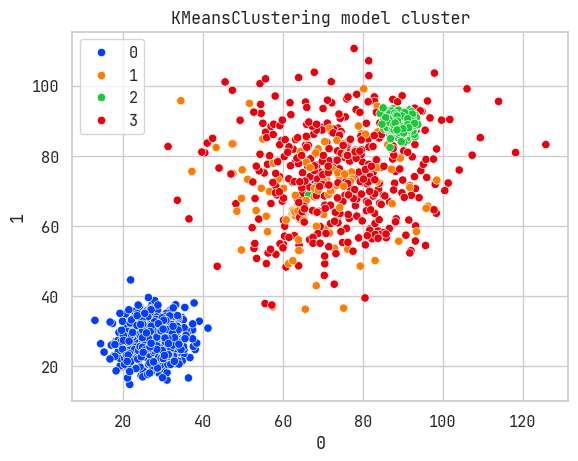

In [5]:
df = pd.DataFrame([x.coords for x in X])

sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=model.labels, palette='bright')
plt.title("KMeansClustering model cluster")
plt.show()

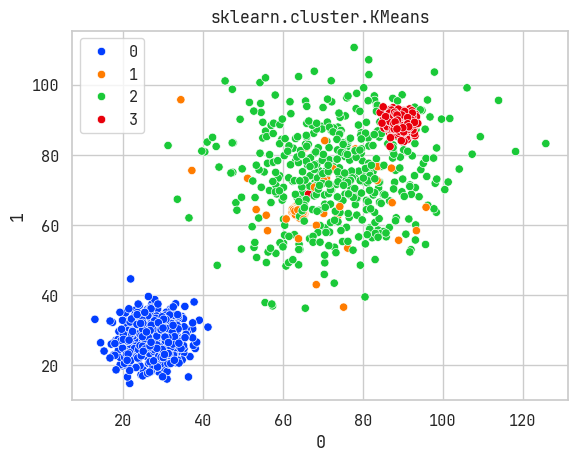

In [6]:
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=n_clusters, random_state=42, init="random", max_iter=10)
cluster_model.fit(df)

sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=cluster_model.labels_, palette="bright")
plt.title("sklearn.cluster.KMeans")
plt.show()